# Softmax Classification (with Cross-Entropy Loss)

In this exercise you will:

- Implement a fully-vectorized **loss function** for the Softmax classifier
- Implement the fully-vectorized expression for its **analytic gradient**
- **Check your implementation** with numerical gradient
- Use a validation set to **tune the learning rate and regularization** strength
- **Optimize** the loss function with **SGD**
- **Visualize** the final learned weights


In [1]:
import time
import random
import math
import numpy as np
from exercise_code.model_savers import save_softmax_classifier
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

## CIFAR-10 Data Loading and Preprocessing

To your convenience, we have taken care of all the input handling. Nevertheless, you should go through the following code line by line so that you understand the general preprocessing pipeline.
The whole datasat is loaded, then subdivided into a training, validation and test dataset (the last one is different from the final evaluation dataset on our server!).

Before proceeding you should *always* take a look at some samples of your dataset, which is already implemented for you. This way you can make sure that the data input/preprocessing has worked as intended and you can get a feeling for the dataset.

In [2]:
from exercise_code.data_utils import load_CIFAR10
# Load the raw CIFAR-10 data
cifar10_dir = 'datasets/'
X, y = load_CIFAR10(cifar10_dir)

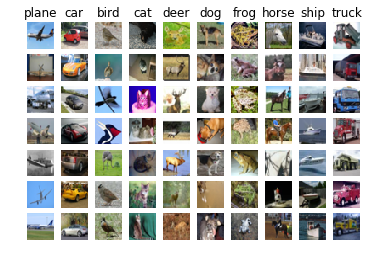

In [3]:
# Visualize some examples from the dataset.
# We show a few examples of training images from each class.
classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
num_classes = len(classes)
samples_per_class = 7
for y_hat, cls in enumerate(classes):
    idxs = np.flatnonzero(y == y_hat)
    idxs = np.random.choice(idxs, samples_per_class, replace=False)
    for i, idx in enumerate(idxs):
        plt_idx = i * num_classes + y_hat + 1
        plt.subplot(samples_per_class, num_classes, plt_idx)
        plt.imshow(X[idx].astype('uint8'))
        plt.axis('off')
        if i == 0:
            plt.title(cls)
plt.show()

In [4]:
# Split the data into train, val, and test sets. In addition we will
# create a small development set as a subset of the data set;
# we can use this for development so our code runs faster.
num_training = 48000
num_validation = 1000
num_test = 1000
num_dev = 500

assert (num_training + num_validation + num_test) == 50000, 'You have not provided a valid data split.'

# Our training set will be the first num_train points from the original
# training set.
mask = range(num_training)
X_train = X[mask]
y_train = y[mask]

# Our validation set will be num_validation points from the original
# training set.
mask = range(num_training, num_training + num_validation)
X_val = X[mask]
y_val = y[mask]

# We use a small subset of the training set as our test set.
mask = range(num_training + num_validation, num_training + num_validation + num_test)
X_test = X[mask]
y_test = y[mask]

# We will also make a development set, which is a small subset of
# the training set. This way the development cycle is faster.
mask = np.random.choice(num_training, num_dev, replace=False)
X_dev = X_train[mask]
y_dev = y_train[mask]

In [5]:
# Preprocessing: reshape the image data into rows
X_train = np.reshape(X_train, (X_train.shape[0], -1))
X_val = np.reshape(X_val, (X_val.shape[0], -1))
X_test = np.reshape(X_test, (X_test.shape[0], -1))
X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))

# As a sanity check, print out the shapes of the data
print('Training data shape: ', X_train.shape)
print('Validation data shape: ', X_val.shape)
print('Test data shape: ', X_test.shape)
print('dev data shape: ', X_dev.shape)

Training data shape:  (48000, 3072)
Validation data shape:  (1000, 3072)
Test data shape:  (1000, 3072)
dev data shape:  (500, 3072)


[130.64297917 135.92841667 132.4100625  130.0744375  135.3130625
 131.70479167 131.0373125  136.18741667 132.48804167 131.65420833]


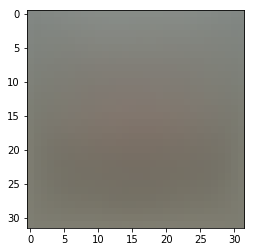

In [6]:
# Preprocessing: subtract the mean image
# first: compute the image mean based on the training data
mean_image = np.mean(X_train, axis=0)
print(mean_image[:10]) # print a few of the elements
plt.figure(figsize=(4,4))
plt.imshow(mean_image.reshape((32,32,3)).astype('uint8')) # visualize the mean image
plt.show()

In [7]:
# second: subtract the mean image from train and test data
X_train -= mean_image
X_val -= mean_image
X_test -= mean_image
X_dev -= mean_image

In [8]:
# third: append the bias dimension of ones (i.e. bias trick) so that our classifier
# only has to worry about optimizing a single weight matrix W.
X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])

print(X_train.shape, X_val.shape, X_test.shape, X_dev.shape)

(48000, 3073) (1000, 3073) (1000, 3073) (500, 3073)


## Softmax Classifier

In this section you will implement the essential elements of a softmax classifier. We will start with the cross-entropy loss and it's gradient with respect to the classifier's weights. We suggest that you first derive these expressions on paper.

### Naive Implementation
First implement a naive cross-entropy loss function with nested loops. Open the file `exercise_code/classifiers/softmax.py` and implement the loss of the softmax classifier into the `cross_entropoy_loss_naive` function.

Running this method might take a while...

In [37]:
from exercise_code.classifiers.softmax import cross_entropoy_loss_naive

# Generate a random weight matrix and use it to compute the loss.
W = np.random.randn(3073, 10) * 0.0001
loss, grad = cross_entropoy_loss_naive(W, X_dev, y_dev, 0.0)

# As a rough sanity check, our loss should be something close to -log(0.1).
print('loss: %f' % loss)
print('sanity check: %f' % (-np.log(0.1)))

loss: 2.349595
sanity check: 2.302585


<div class="alert alert-info">
    <h3>Inline Question</h3>
    <p>Why do we expect our loss to be close to -log(0.1)? Explain briefly.</p>
</div>

Complete the implementation of the `cross_entropoy_loss_naive` function and implement a (naive) version of the gradient that uses nested loops. Use the following cell to check your results:

In [28]:
from exercise_code.gradient_check import grad_check_sparse
# We take a smaller dev set since the naive implementation takes quite some while
X_dev_small, y_dev_small = X_dev[:10], y_dev[:10]

loss, grad = cross_entropoy_loss_naive(W, X_dev_small, y_dev_small, 0.0)

# We use numeric gradient checking as a debugging tool.
# The numeric gradient should be close to the analytic gradient.
f = lambda w: cross_entropoy_loss_naive(w, X_dev_small, y_dev_small, 0.0)[0]
grad_numerical = grad_check_sparse(f, W, grad, num_checks=3)

# Again, running this might take a while!

numerical: 2.1659122261263875 analytic: 2.1659117595353963, relative error: 1.0771236151828607e-07
numerical: -2.530993084981503 analytic: -2.5309930942112357, relative error: 1.8233421046761507e-09
numerical: -0.16599473160461287 analytic: -0.16599461971524399, relative error: 3.370269812460916e-07


In [27]:
# Do another gradient check with regularization
loss, grad = cross_entropoy_loss_naive(W, X_dev_small, y_dev_small, 1e2)
f = lambda w: cross_entropoy_loss_naive(w, X_dev_small, y_dev_small, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, num_checks=3)

numerical: 0.08690399058153274 analytic: 0.08690390688925849, relative error: 4.815216999205849e-07
numerical: 5.850003518514945 analytic: 5.850003699579667, relative error: 1.547560774548676e-08
numerical: -2.830003746545628 analytic: -2.830003598087607, relative error: 2.6229298293823767e-08


### Vectorized Implementation
Now that we have a naive implementation of the cross-entropy loss and its gradient, implement a vectorized version in `cross_entropoy_loss_vectorized`.

The two versions should compute the same results, but the vectorized version should be much faster.

In [43]:
from exercise_code.classifiers.softmax import cross_entropoy_loss_vectorized

tic = time.time()
loss_naive, grad_naive = cross_entropoy_loss_naive(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('naive loss: %e computed in %fs' % (loss_naive, toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = cross_entropoy_loss_vectorized(W, X_dev, y_dev, 0.00001)
toc = time.time()
print('vectorized loss: %e computed in %fs' % (loss_vectorized, toc - tic))

# We use the Frobenius norm to compare the two versions of the gradient.
grad_difference = np.linalg.norm(grad_naive - grad_vectorized, ord='fro')
print('Loss difference: %f' % np.abs(loss_naive - loss_vectorized))
print('Gradient difference: %f' % grad_difference)

Loss naive: 2.349594638895518
naive loss: 2.349595e+00 computed in 25.092376s
Loss vec: 2.349593873618482
vectorized loss: 2.349594e+00 computed in 0.003988s
Loss difference: 0.000001
Gradient difference: 0.000000


<div class="alert alert-info">
    <h3>Inline Question</h3>
    <p>When you compute the softmax distribution, you are dividing by a sum of exponentials, i.e. potentially very large numbers, which can be numerically unstable. Do you see a way to avoid this problem?
</p>
    <p>(Hint: exploit properties of the exponential function to arrive at an expression that is mathematically the same, but numerically more stable)</p>
</p>
</div>

### Stochastic Gradient Descent

We now have vectorized and efficient expressions for the loss, the gradient and our gradient matches the numerical gradient. We are therefore ready to usw SGD to minimize the loss. In the file `exercise_code/classifiers/linear_classifier.py`, implement SGD in the `LinearClassifier.train` method and test it with the code below.

In [9]:
from exercise_code.classifiers.softmax import SoftmaxClassifier

# The SoftmaxClassifier class inherits from LinearClassifier
softmax = SoftmaxClassifier()
tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7, reg=5e4,
                          num_iters=1500, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))

iteration 0 / 1500: loss 763.223467
iteration 100 / 1500: loss 280.384531
iteration 200 / 1500: loss 103.907168
iteration 300 / 1500: loss 39.347537
iteration 400 / 1500: loss 15.670634
iteration 500 / 1500: loss 7.096928
iteration 600 / 1500: loss 3.886424
iteration 700 / 1500: loss 2.722641
iteration 800 / 1500: loss 2.331521
iteration 900 / 1500: loss 2.218123
iteration 1000 / 1500: loss 2.135270
iteration 1100 / 1500: loss 2.119123
iteration 1200 / 1500: loss 2.085117
iteration 1300 / 1500: loss 2.097592
iteration 1400 / 1500: loss 2.045822
That took 16.718135s


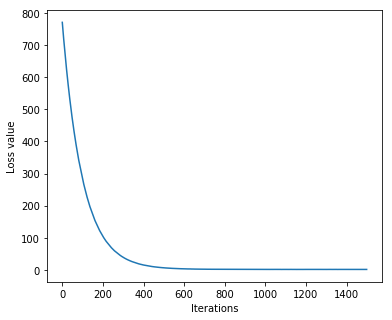

In [46]:
# A useful debugging strategy is to plot the loss as a function of iterations:
plt.figure(figsize=(6,5))
plt.plot(loss_hist)
plt.xlabel('Iterations')
plt.ylabel('Loss value')
plt.show()

Write the `LinearClassifier.predict` method and evaluate the performance on both the training and validation set:

In [47]:
y_train_pred = softmax.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

training accuracy: 0.332458
validation accuracy: 0.325000


### Training your Softmax Classifier
Use the validation set to tune hyperparameters (regularization strength and learning rate). You should experiment with different ranges for the learning rates and regularization strengths; if you are careful you should be able to get a classification accuracy of over 0.35 on the validation set. Implement the `softmax_hyperparameter_tuning` function in `exercise_code/classifiers/softmax.py`.

In [29]:
from exercise_code.classifiers.softmax import SoftmaxClassifier, softmax_hyperparameter_tuning

best_softmax, results, all_classifiers = softmax_hyperparameter_tuning(X_train, y_train, X_val, y_val)

iteration 0 / 8500: loss 6.350509
iteration 100 / 8500: loss 2.935980
iteration 200 / 8500: loss 2.656269
iteration 300 / 8500: loss 2.504882
iteration 400 / 8500: loss 2.440877
iteration 500 / 8500: loss 2.466599
iteration 600 / 8500: loss 2.256374
iteration 700 / 8500: loss 2.318375
iteration 800 / 8500: loss 2.335230
iteration 900 / 8500: loss 2.283629
iteration 1000 / 8500: loss 2.175843
iteration 1100 / 8500: loss 2.201893
iteration 1200 / 8500: loss 2.091318
iteration 1300 / 8500: loss 2.176809
iteration 1400 / 8500: loss 2.042447
iteration 1500 / 8500: loss 2.083592
iteration 1600 / 8500: loss 2.256759
iteration 1700 / 8500: loss 2.170281
iteration 1800 / 8500: loss 2.098225
iteration 1900 / 8500: loss 2.116875
iteration 2000 / 8500: loss 1.982960
iteration 2100 / 8500: loss 1.942830
iteration 2200 / 8500: loss 2.068112
iteration 2300 / 8500: loss 1.977645
iteration 2400 / 8500: loss 1.996580
iteration 2500 / 8500: loss 2.036870
iteration 2600 / 8500: loss 1.874285
iteration 270

iteration 4800 / 8500: loss 1.804529
iteration 4900 / 8500: loss 1.801308
iteration 5000 / 8500: loss 1.854186
iteration 5100 / 8500: loss 1.950395
iteration 5200 / 8500: loss 2.065367
iteration 5300 / 8500: loss 1.882550
iteration 5400 / 8500: loss 1.889346
iteration 5500 / 8500: loss 1.749468
iteration 5600 / 8500: loss 1.808741
iteration 5700 / 8500: loss 1.842590
iteration 5800 / 8500: loss 1.926953
iteration 5900 / 8500: loss 1.915184
iteration 6000 / 8500: loss 1.747613
iteration 6100 / 8500: loss 1.804589
iteration 6200 / 8500: loss 1.988216
iteration 6300 / 8500: loss 1.879163
iteration 6400 / 8500: loss 1.939640
iteration 6500 / 8500: loss 1.683424
iteration 6600 / 8500: loss 1.893045
iteration 6700 / 8500: loss 1.698817
iteration 6800 / 8500: loss 1.885601
iteration 6900 / 8500: loss 1.744463
iteration 7000 / 8500: loss 1.674425
iteration 7100 / 8500: loss 1.761380
iteration 7200 / 8500: loss 1.796298
iteration 7300 / 8500: loss 1.882036
iteration 7400 / 8500: loss 1.812906
i

iteration 700 / 8500: loss 2.258564
iteration 800 / 8500: loss 2.348314
iteration 900 / 8500: loss 2.368971
iteration 1000 / 8500: loss 2.220148
iteration 1100 / 8500: loss 2.170710
iteration 1200 / 8500: loss 2.184017
iteration 1300 / 8500: loss 2.071651
iteration 1400 / 8500: loss 2.077799
iteration 1500 / 8500: loss 2.106593
iteration 1600 / 8500: loss 2.172617
iteration 1700 / 8500: loss 2.147156
iteration 1800 / 8500: loss 2.087129
iteration 1900 / 8500: loss 1.975062
iteration 2000 / 8500: loss 2.159932
iteration 2100 / 8500: loss 2.080405
iteration 2200 / 8500: loss 1.999810
iteration 2300 / 8500: loss 2.047977
iteration 2400 / 8500: loss 2.135105
iteration 2500 / 8500: loss 2.007166
iteration 2600 / 8500: loss 1.881330
iteration 2700 / 8500: loss 1.848476
iteration 2800 / 8500: loss 2.095654
iteration 2900 / 8500: loss 1.859148
iteration 3000 / 8500: loss 1.985248
iteration 3100 / 8500: loss 1.997890
iteration 3200 / 8500: loss 1.857588
iteration 3300 / 8500: loss 1.971989
iter

iteration 5400 / 8500: loss 1.956080
iteration 5500 / 8500: loss 1.828411
iteration 5600 / 8500: loss 1.852058
iteration 5700 / 8500: loss 1.824421
iteration 5800 / 8500: loss 1.827298
iteration 5900 / 8500: loss 1.851362
iteration 6000 / 8500: loss 1.757989
iteration 6100 / 8500: loss 1.813748
iteration 6200 / 8500: loss 1.786278
iteration 6300 / 8500: loss 1.848240
iteration 6400 / 8500: loss 1.826391
iteration 6500 / 8500: loss 1.792797
iteration 6600 / 8500: loss 1.859839
iteration 6700 / 8500: loss 1.783524
iteration 6800 / 8500: loss 1.679250
iteration 6900 / 8500: loss 1.769066
iteration 7000 / 8500: loss 1.744316
iteration 7100 / 8500: loss 1.843468
iteration 7200 / 8500: loss 1.760558
iteration 7300 / 8500: loss 1.764665
iteration 7400 / 8500: loss 1.889248
iteration 7500 / 8500: loss 1.815540
iteration 7600 / 8500: loss 1.732873
iteration 7700 / 8500: loss 1.833757
iteration 7800 / 8500: loss 1.652408
iteration 7900 / 8500: loss 1.844912
iteration 8000 / 8500: loss 1.853198
i

iteration 1300 / 8500: loss 2.125350
iteration 1400 / 8500: loss 1.992828
iteration 1500 / 8500: loss 2.049026
iteration 1600 / 8500: loss 2.053316
iteration 1700 / 8500: loss 2.055676
iteration 1800 / 8500: loss 2.055643
iteration 1900 / 8500: loss 1.942780
iteration 2000 / 8500: loss 2.070623
iteration 2100 / 8500: loss 2.089955
iteration 2200 / 8500: loss 2.184789
iteration 2300 / 8500: loss 1.997555
iteration 2400 / 8500: loss 1.923473
iteration 2500 / 8500: loss 2.106822
iteration 2600 / 8500: loss 2.116898
iteration 2700 / 8500: loss 2.005721
iteration 2800 / 8500: loss 2.160217
iteration 2900 / 8500: loss 1.999736
iteration 3000 / 8500: loss 1.956319
iteration 3100 / 8500: loss 1.911036
iteration 3200 / 8500: loss 2.075540
iteration 3300 / 8500: loss 1.864129
iteration 3400 / 8500: loss 1.935786
iteration 3500 / 8500: loss 1.802720
iteration 3600 / 8500: loss 1.828473
iteration 3700 / 8500: loss 1.873930
iteration 3800 / 8500: loss 1.817592
iteration 3900 / 8500: loss 1.855267
i

iteration 6100 / 8500: loss 1.974764
iteration 6200 / 8500: loss 1.709087
iteration 6300 / 8500: loss 1.975018
iteration 6400 / 8500: loss 1.744975
iteration 6500 / 8500: loss 1.781531
iteration 6600 / 8500: loss 1.778365
iteration 6700 / 8500: loss 1.931156
iteration 6800 / 8500: loss 1.824991
iteration 6900 / 8500: loss 1.786464
iteration 7000 / 8500: loss 1.759096
iteration 7100 / 8500: loss 1.736682
iteration 7200 / 8500: loss 1.776812
iteration 7300 / 8500: loss 1.790311
iteration 7400 / 8500: loss 1.842516
iteration 7500 / 8500: loss 1.716769
iteration 7600 / 8500: loss 1.813395
iteration 7700 / 8500: loss 1.811342
iteration 7800 / 8500: loss 1.718614
iteration 7900 / 8500: loss 1.837480
iteration 8000 / 8500: loss 1.711548
iteration 8100 / 8500: loss 1.725751
iteration 8200 / 8500: loss 1.776666
iteration 8300 / 8500: loss 1.740221
iteration 8400 / 8500: loss 1.835001
LR: 2.3e-06, R: 31, NIter: 8500, Train_Acc: 0.4428958333333333, Val_Acc: 0.412. Took 88.24840354919434
iteration

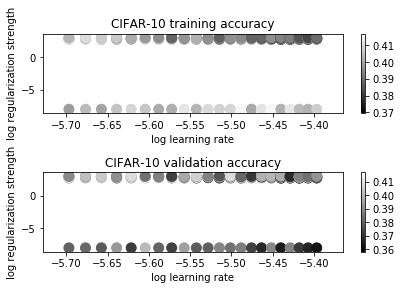

In [89]:
# Visualize the validation results
x_scatter = [math.log10(x[0]+1e-8) for x in results]
y_scatter = [math.log10(x[1]+1e-8) for x in results]

# plot training accuracy
marker_size = 100
colors = [results[x][0] for x in results]
plt.subplot(2, 1, 1)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 training accuracy')

# plot validation accuracy
colors = [results[x][1] for x in results] # default size of markers is 20
plt.subplot(2, 1, 2)
plt.scatter(x_scatter, y_scatter, marker_size, c=colors)
plt.colorbar()
plt.xlabel('log learning rate')
plt.ylabel('log regularization strength')
plt.title('CIFAR-10 validation accuracy')

plt.tight_layout()
plt.show()

In [96]:
# if you want to take a look at the other classifiers assign them to best_softmax here
sorted_classifiers = sorted(all_classifiers, key=lambda x : x[1])
best_softmax = sorted_classifiers[41]

IndexError: list index out of range

In [31]:
best_softmax_temp = best_softmax

In [37]:
from exercise_code.classifiers.softmax import SoftmaxClassifier
softmax_alp = SoftmaxClassifier()
loss_hist_alp = softmax_alp.train(X_train, y_train
                                  , learning_rate=2.25e-06
                                  , reg=31
                                  , num_iters=8500
                                  , verbose=True)
best_softmax = softmax_alp

iteration 0 / 8500: loss 6.240535
iteration 100 / 8500: loss 2.812203
iteration 200 / 8500: loss 2.482749
iteration 300 / 8500: loss 2.438867
iteration 400 / 8500: loss 2.389615
iteration 500 / 8500: loss 2.569500
iteration 600 / 8500: loss 2.347776
iteration 700 / 8500: loss 2.202642
iteration 800 / 8500: loss 2.301256
iteration 900 / 8500: loss 2.180185
iteration 1000 / 8500: loss 2.354131
iteration 1100 / 8500: loss 2.193621
iteration 1200 / 8500: loss 2.252825
iteration 1300 / 8500: loss 2.108718
iteration 1400 / 8500: loss 2.225041
iteration 1500 / 8500: loss 2.207796
iteration 1600 / 8500: loss 2.116783
iteration 1700 / 8500: loss 2.113122
iteration 1800 / 8500: loss 2.227366
iteration 1900 / 8500: loss 2.017452
iteration 2000 / 8500: loss 1.977708
iteration 2100 / 8500: loss 2.073897
iteration 2200 / 8500: loss 2.019416
iteration 2300 / 8500: loss 2.112241
iteration 2400 / 8500: loss 1.996526
iteration 2500 / 8500: loss 2.099990
iteration 2600 / 8500: loss 1.895951
iteration 270

In [41]:
# evaluate on test set
# Evaluate the best softmax on test set
y_test_pred = best_softmax.predict(X_test)
test_accuracy = np.mean(y_test == y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.407000


In [32]:
whole_data = np.reshape(X, (X.shape[0], -1))
whole_data -= np.mean(whole_data, axis=0)
whole_data = np.hstack([whole_data, np.ones((whole_data.shape[0], 1))])

In [33]:
softmax_alp = SoftmaxClassifier()
loss_hist_alp = softmax_alp.train(whole_data
                                  , y
                                  , learning_rate=2.25e-06
                                  , reg=31
                                  , num_iters=8500
                                  , verbose=True)
best_softmax = softmax_alp

iteration 0 / 8500: loss 6.888158
iteration 100 / 8500: loss 2.968977
iteration 200 / 8500: loss 2.785028
iteration 300 / 8500: loss 2.548845
iteration 400 / 8500: loss 2.623246
iteration 500 / 8500: loss 2.348968
iteration 600 / 8500: loss 2.434360
iteration 700 / 8500: loss 2.297596
iteration 800 / 8500: loss 2.264451
iteration 900 / 8500: loss 2.279979
iteration 1000 / 8500: loss 2.350788
iteration 1100 / 8500: loss 2.230604
iteration 1200 / 8500: loss 2.106471
iteration 1300 / 8500: loss 1.994076
iteration 1400 / 8500: loss 2.102931
iteration 1500 / 8500: loss 2.012605
iteration 1600 / 8500: loss 2.054384
iteration 1700 / 8500: loss 2.075553
iteration 1800 / 8500: loss 2.117147
iteration 1900 / 8500: loss 2.258454
iteration 2000 / 8500: loss 2.089080
iteration 2100 / 8500: loss 2.175444
iteration 2200 / 8500: loss 2.044068
iteration 2300 / 8500: loss 2.049524
iteration 2400 / 8500: loss 2.034466
iteration 2500 / 8500: loss 2.069999
iteration 2600 / 8500: loss 1.993951
iteration 270

In [39]:
# evaluate on test set
# Evaluate the best softmax on test set
whole_y_test_pred = best_softmax.predict(whole_data)
test_accuracy = np.mean(y == whole_y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.438700


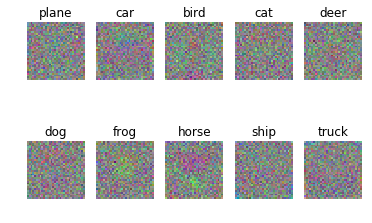

In [40]:
# Visualize the learned weights for each class
#best_softmax = sorted_classifiers[idx][0]
w = best_softmax.W[:-1,:] # strip out the bias
w = w.reshape(32, 32, 3, 10)

w_min, w_max = np.min(w), np.max(w)

classes = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
for i in range(10):
  plt.subplot(2, 5, i + 1)

  # Rescale the weights to be between 0 and 255
  wimg = 255.0 * (w[:, :, :, i].squeeze() - w_min) / (w_max - w_min)
  plt.imshow(wimg.astype('uint8'))
  plt.axis('off')
  plt.title(classes[i])

<div class="alert alert-info">
    <h3>Inline Question</h3>
    <p>Describe what your visualized Softmax weights look like.</p>
</div>

## Save the model

When you are satisfied with your training, save the model for submission. Your final score is computed by `accuracy * 100`. In order to pass this exercise, you have to achieve a score higher than __35__.

<div class="alert alert-danger">
    <h3>Warning</h3>
    <p>You might get an error like this:</p>
    <p>PicklingError: Can't pickle `<class 'exercise_code.classifiers.softmax.SoftmaxClassifier'>`: it's not the same object as exercise_code.classifiers.softmax.SoftmaxClassifier</p>
    <p>The reason is that we are using autoreload and working on this class during the notebook session. If you get this error simply restart the kernel and rerun the whole script (Kernel -> Restart & Run All) or only the important cells for generating your model.</p>
</div>

In [42]:
from exercise_code.model_savers import save_softmax_classifier
#from exercise_code.classifiers.softmax import SoftmaxClassifier

save_softmax_classifier(best_softmax)

## Submission 1

The softmax classifier is submission 1. To earn the bonus you need to achieve a score higher than __35__.

In [36]:
# Do another gradient check with regularization
loss, grad = cross_entropoy_loss_naive(W, X_dev_small, y_dev_small, 1e2)
f = lambda w: cross_entropoy_loss_naive(w, X_dev_small, y_dev_small, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, num_checks=3)

# Do another gradient check with regularization
loss, grad = cross_entropoy_loss_vectorized(W, X_dev_small, y_dev_small, 1e2)
f = lambda w: cross_entropoy_loss_vectorized(w, X_dev_small, y_dev_small, 1e2)[0]
grad_numerical = grad_check_sparse(f, W, grad, num_checks=3)

numerical: -9.571695794785562 analytic: -9.571695809401517, relative error: 7.634987034161303e-10
numerical: 0.8103431061945442 analytic: 0.8103430307146043, relative error: 4.6572829948342764e-08
numerical: 12.148416258717097 analytic: 12.14841606154856, relative error: 8.114989431457472e-09
numerical: 2.0812244368562105 analytic: 2.2931782060979677, relative error: 0.04845319156505855
numerical: 2.907575279587071 analytic: 2.875342164701967, relative error: 0.0055738500844302865
numerical: 2.2103182692134737 analytic: 2.3239092726630046, relative error: 0.025051897462234886


iteration 0 / 3000: loss 13.288105
iteration 100 / 3000: loss 7.863505
iteration 200 / 3000: loss 6.009711
iteration 300 / 3000: loss 4.926967
iteration 400 / 3000: loss 4.106548
iteration 500 / 3000: loss 3.539809
iteration 600 / 3000: loss 2.974119
iteration 700 / 3000: loss 2.659275
iteration 800 / 3000: loss 2.451202
iteration 900 / 3000: loss 2.226373
iteration 1000 / 3000: loss 2.102009
iteration 1100 / 3000: loss 1.933198
iteration 1200 / 3000: loss 1.881311
iteration 1300 / 3000: loss 1.926330
iteration 1400 / 3000: loss 1.969726
iteration 1500 / 3000: loss 1.783731
iteration 1600 / 3000: loss 1.955576
iteration 1700 / 3000: loss 1.797573
iteration 1800 / 3000: loss 1.793196
iteration 1900 / 3000: loss 1.726166
iteration 2000 / 3000: loss 1.849594
iteration 2100 / 3000: loss 1.774660
iteration 2200 / 3000: loss 1.758795
iteration 2300 / 3000: loss 1.884293
iteration 2400 / 3000: loss 1.781488
iteration 2500 / 3000: loss 1.787612
iteration 2600 / 3000: loss 1.817624
iteration 27

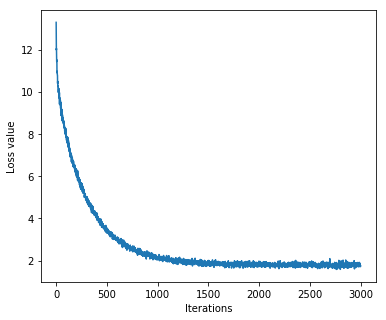

training accuracy: 0.416938
validation accuracy: 0.408000


In [87]:
from exercise_code.classifiers.softmax import SoftmaxClassifier

# The SoftmaxClassifier class inherits from LinearClassifier
softmax = SoftmaxClassifier()
tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=30e-7, reg=500,
                          num_iters=3000, verbose=True)
toc = time.time()
print('That took %fs' % (toc - tic))
# A useful debugging strategy is to plot the loss as a function of iterations:
plt.figure(figsize=(6,5))
plt.plot(loss_hist)
plt.xlabel('Iterations')
plt.ylabel('Loss value')
plt.show()

y_train_pred = softmax.predict(X_train)
print('training accuracy: %f' % (np.mean(y_train == y_train_pred), ))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: %f' % (np.mean(y_val == y_val_pred), ))

In [125]:
 for lr in np.linspace(1e-8, 100e-8, 50):
        for reg in np.linspace(100e2, 0, 100):
            print(str(lr) + " . " + str(reg))

1e-08 . 10000.0
1e-08 . 9898.9898989899
1e-08 . 9797.979797979799
1e-08 . 9696.969696969696
1e-08 . 9595.959595959595
1e-08 . 9494.949494949495
1e-08 . 9393.939393939394
1e-08 . 9292.929292929293
1e-08 . 9191.919191919193
1e-08 . 9090.90909090909
1e-08 . 8989.89898989899
1e-08 . 8888.888888888889
1e-08 . 8787.878787878788
1e-08 . 8686.868686868687
1e-08 . 8585.858585858587
1e-08 . 8484.848484848484
1e-08 . 8383.838383838383
1e-08 . 8282.828282828283
1e-08 . 8181.818181818182
1e-08 . 8080.808080808081
1e-08 . 7979.79797979798
1e-08 . 7878.787878787879
1e-08 . 7777.777777777777
1e-08 . 7676.767676767677
1e-08 . 7575.757575757576
1e-08 . 7474.747474747475
1e-08 . 7373.737373737374
1e-08 . 7272.727272727272
1e-08 . 7171.717171717171
1e-08 . 7070.707070707071
1e-08 . 6969.69696969697
1e-08 . 6868.686868686869
1e-08 . 6767.676767676768
1e-08 . 6666.666666666666
1e-08 . 6565.656565656565
1e-08 . 6464.646464646465
1e-08 . 6363.636363636364
1e-08 . 6262.626262626263
1e-08 . 6161.616161616162
1e

4.544897959183674e-07 . 9292.929292929293
4.544897959183674e-07 . 9191.919191919193
4.544897959183674e-07 . 9090.90909090909
4.544897959183674e-07 . 8989.89898989899
4.544897959183674e-07 . 8888.888888888889
4.544897959183674e-07 . 8787.878787878788
4.544897959183674e-07 . 8686.868686868687
4.544897959183674e-07 . 8585.858585858587
4.544897959183674e-07 . 8484.848484848484
4.544897959183674e-07 . 8383.838383838383
4.544897959183674e-07 . 8282.828282828283
4.544897959183674e-07 . 8181.818181818182
4.544897959183674e-07 . 8080.808080808081
4.544897959183674e-07 . 7979.79797979798
4.544897959183674e-07 . 7878.787878787879
4.544897959183674e-07 . 7777.777777777777
4.544897959183674e-07 . 7676.767676767677
4.544897959183674e-07 . 7575.757575757576
4.544897959183674e-07 . 7474.747474747475
4.544897959183674e-07 . 7373.737373737374
4.544897959183674e-07 . 7272.727272727272
4.544897959183674e-07 . 7171.717171717171
4.544897959183674e-07 . 7070.707070707071
4.544897959183674e-07 . 6969.69696969

8.585714285714287e-07 . 9292.929292929293
8.585714285714287e-07 . 9191.919191919193
8.585714285714287e-07 . 9090.90909090909
8.585714285714287e-07 . 8989.89898989899
8.585714285714287e-07 . 8888.888888888889
8.585714285714287e-07 . 8787.878787878788
8.585714285714287e-07 . 8686.868686868687
8.585714285714287e-07 . 8585.858585858587
8.585714285714287e-07 . 8484.848484848484
8.585714285714287e-07 . 8383.838383838383
8.585714285714287e-07 . 8282.828282828283
8.585714285714287e-07 . 8181.818181818182
8.585714285714287e-07 . 8080.808080808081
8.585714285714287e-07 . 7979.79797979798
8.585714285714287e-07 . 7878.787878787879
8.585714285714287e-07 . 7777.777777777777
8.585714285714287e-07 . 7676.767676767677
8.585714285714287e-07 . 7575.757575757576
8.585714285714287e-07 . 7474.747474747475
8.585714285714287e-07 . 7373.737373737374
8.585714285714287e-07 . 7272.727272727272
8.585714285714287e-07 . 7171.717171717171
8.585714285714287e-07 . 7070.707070707071
8.585714285714287e-07 . 6969.69696969

In [98]:
len(all_classifiers)

0

In [124]:
X.shape

(50000, 32, 32, 3)

In [129]:
whole_data.shape

(50000, 3072)

In [131]:
y.shape

(50000,)

In [132]:
# evaluate on test set
# Evaluate the best softmax on test set
whole_y_test_pred = best_softmax.predict(whole_data)
test_accuracy = np.mean(y == whole_y_test_pred)
print('softmax on raw pixels final test set accuracy: %f' % (test_accuracy, ))

softmax on raw pixels final test set accuracy: 0.401920


In [22]:
best_softmax.W.shape

(3073, 10)

In [23]:
whole_data.shape

(50000, 3072)